In [1]:
import re
import sys
from collections import Counter

import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tempfile

In [2]:
sys.path.append(os.path.abspath('../backend'))
from src.Web.GoogleCloudStorage import list_files, get_gcs_client

In [3]:
def clean_text(text):
    # Remove punctuation and symbols
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

In [4]:
# Define function to generate a word cloud visualization
def visualize_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Define function to plot word frequency as a bar chart
def visualize_word_frequency(text, top_n=10):
    # Clean text and split into words
    cleaned_text = clean_text(text)
    words = cleaned_text.split()

    # Remove common stop words
    stop_words = {"to", "and", "the", "a", "of", "in", "is", "for", "with", "on", "by"}
    filtered_words = [word for word in words if word not in stop_words]

    # Count word frequencies
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(top_n)

    # Extract words and their frequencies for plotting
    words, frequencies = zip(*top_words)

    # Plot the top words
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title("Top Word Frequencies (Filtered and Cleaned)")
    plt.show()

In [5]:
# Function to read file content directly from GCS
def read_file_from_gcs(bucket_name, filename):
    client = get_gcs_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(filename)
    
    if not blob.exists():
        raise FileNotFoundError(f"The file '{filename}' does not exist in the bucket.")
    
    return blob.download_as_text()

# Main function to list files and visualize a selected one
def list_and_visualize_file():
    try:
        # List available files in GCS
        files = list_files()
        print("Available files in the GCS bucket:")
        for idx, file_name in enumerate(files, start=1):
            print(f"{idx}. {file_name}")

        # Choose a file to visualize
        file_index = 1000
        selected_file = files[file_index]
        text_data = read_file_from_gcs(os.getenv("GCS_BUCKET_NAME"), selected_file)

        visualize_word_cloud(text_data)
        word_counts = {}
        for word in text_data.split():
            word_counts[word] = word_counts.get(word, 0) + 1
        
        visualize_word_frequency(word_counts)

    except Exception as e:
        print(f"An error occurred: {e}")

13:11:56 | INFO     | list_files      | Listed 39969 files from GCS bucket 'scraped_web_data'.


Available files in the GCS bucket:
1. /ScrapedData/924f9b77405daa4e6611006e1c1ccce7.txt
2. 11-03-test/academicaffairs.ucsc.edu_accreditation_
3. 11-03-test/admissions.ucsc.edu_
4. 11-03-test/admissions.ucsc.edu_#main-content
5. 11-03-test/admissions.ucsc.edu_attend-ucsc
6. 11-03-test/admissions.ucsc.edu_attend-ucsc_uc-application-tips-you
7. 11-03-test/admissions.ucsc.edu_contact-us
8. 11-03-test/admissions.ucsc.edu_contact-us#find-your-representative
9. 11-03-test/admissions.ucsc.edu_contact-us#sign-up-for-our-mailing-list
10. 11-03-test/admissions.ucsc.edu_counselors
11. 11-03-test/admissions.ucsc.edu_events
12. 11-03-test/admissions.ucsc.edu_find-your-program
13. 11-03-test/admissions.ucsc.edu_first-year-student
14. 11-03-test/admissions.ucsc.edu_international-students
15. 11-03-test/admissions.ucsc.edu_majors-academics
16. 11-03-test/admissions.ucsc.edu_out-state-students
17. 11-03-test/admissions.ucsc.edu_parent
18. 11-03-test/admissions.ucsc.edu_posts_dates-deadlines
19. 11-03-te

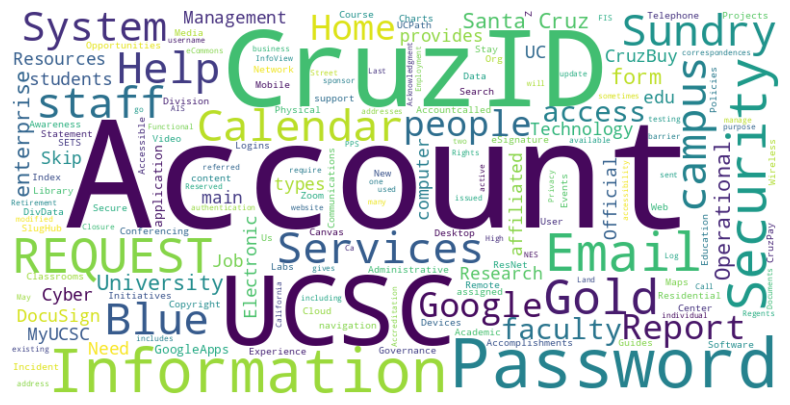

An error occurred: expected string or bytes-like object, got 'dict'


In [6]:
list_and_visualize_file()

In [13]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.cloud import storage
from google.oauth2 import service_account
import os
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
import os

# Replace with your actual credentials file path
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/shotomorisaki/Engineering/cse144-collegeassist/backend/keyfile.json"

In [18]:
terms = ["ucsc", "university of california santa cruz", "student", "admission", "campus", "degree"]

def compute_similarity_matrix_tfidf(texts):
    vectorizer = TfidfVectorizer(vocabulary=terms)
    tfidf_matrix = vectorizer.fit_transform(texts).toarray()
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix
# Preprocess text function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and special characters
    return text

# Function to compute cosine similarity for selected terms
def compute_similarity_matrix(texts, terms):
    # Vectorize each document for the specific terms
    vectorizer = CountVectorizer(vocabulary=terms)
    term_matrix = vectorizer.fit_transform(texts).toarray()

    # Calculate cosine similarity between vectors
    similarity_matrix = cosine_similarity(term_matrix)
    return similarity_matrix

# Function to visualize similarity matrix as a heatmap
def plot_similarity_heatmap(similarity_matrix, file_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, xticklabels=file_names, yticklabels=file_names, cmap="YlGnBu")
    plt.title("Cosine Similarity of Text Files based on Specific Terms")
    plt.xlabel("Files")
    plt.ylabel("Files")
    plt.show()

# Function to read file content directly from GCS
def read_file_from_gcs(bucket_name, filename):
    client = get_gcs_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(filename)
    
    if not blob.exists():
        raise FileNotFoundError(f"The file '{filename}' does not exist in the bucket.")
    
    return blob.download_as_text()  # Directly return text content

# Function to initialize Google Cloud Storage client
def get_gcs_client():
    """Initialize and return a Google Cloud Storage client."""
    key_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
    if not key_path:
        raise EnvironmentError("GOOGLE_APPLICATION_CREDENTIALS environment variable is not set.")

    credentials = service_account.Credentials.from_service_account_file(key_path)
    return storage.Client(credentials=credentials)

# Main function to download files and visualize similarity
def visualize_file_similarity():
    # List available files in GCS
    files = list_files()
    
    # Filter files to only include text files or relevant subset
    text_files = [file for file in files if file.endswith('.txt')]
    
    # Limit the number of files to a reasonable amount for visualization (e.g., top 10)
    text_files = text_files[:10]  # Select the first 10 files for demonstration

    # Download content for each selected file
    text_data_list = []
    for filename in text_files:
        try:
            text_data = read_file_from_gcs(os.getenv("GCS_BUCKET_NAME"), filename)
            text_data_list.append(text_data)
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
            continue

    # Check if any data was downloaded
    if not text_data_list:
        print("No files were downloaded successfully. Please check your GCS settings and try again.")
        return

    # Preprocess each document
    preprocessed_texts = [preprocess_text(text) for text in text_data_list]

    # Define a broader set of terms of interest
    terms = ["ucsc", "university of california santa cruz", "student", "admission", "campus", "degree"]

    # Compute similarity matrix using TF-IDF
    similarity_matrix = compute_similarity_matrix_tfidf(preprocessed_texts)

    # Plot heatmap of similarity matrix
    plot_similarity_heatmap(similarity_matrix, text_files)

# Run the visualization
def plot_similarity_bar_graph(similarity_matrix, file_names, reference_index=None):
    if reference_index is not None:
        # Approach 1: Cosine similarity with a reference file
        similarities = similarity_matrix[reference_index]
        title = f"Cosine Similarity of Files to Reference File: {file_names[reference_index]}"
    else:
        # Approach 2: Average cosine similarity with all other files
        similarities = similarity_matrix.mean(axis=1)
        title = "Average Cosine Similarity of Each File to All Other Files"

    # Plotting the bar graph
    plt.figure(figsize=(12, 6))
    plt.barh(file_names, similarities)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Files")
    plt.title(title)
    plt.gca().invert_yaxis()  # To have the highest similarity on top
    plt.show()

# Assuming `similarity_matrix` is computed and `file_names` is the list of file names
# Example usage:
# Use reference_index=0 to compare with the first file, or omit it for average similarity
plot_similarity_bar_graph(similarity_matrix, file_names, reference_index=0)


NameError: name 'similarity_matrix' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_similarity_bar_graph(similarity_matrix, file_names, reference_index=None):
    if reference_index is not None:
        # Approach 1: Cosine similarity with a reference file
        similarities = similarity_matrix[reference_index]
        title = f"Cosine Similarity of Files to Reference File: {file_names[reference_index]}"
    else:
        # Approach 2: Average cosine similarity with all other files
        similarities = similarity_matrix.mean(axis=1)
        title = "Average Cosine Similarity of Each File to All Other Files"

    # Plotting the bar graph
    plt.figure(figsize=(12, 6))
    plt.barh(file_names, similarities)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Files")
    plt.title(title)
    plt.gca().invert_yaxis()  # To have the highest similarity on top
    plt.show()

# Assuming `similarity_matrix` is computed and `file_names` is the list of file names
# Example usage:
# Use reference_index=0 to compare with the first file, or omit it for average similarity
plot_similarity_bar_graph(similarity_matrix, file_names, reference_index=0)


NameError: name 'similarity_matrix' is not defined

In [30]:
import os
import re
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from google.cloud import storage
from google.oauth2 import service_account
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import logging
import random
import umap

# -------------------- Setup Logging --------------------

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# -------------------- Download NLTK Data --------------------

nltk.download('stopwords')
nltk.download('wordnet')

# -------------------- GCS Utility Functions --------------------

def get_gcs_client():
    """
    Initialize and return a Google Cloud Storage client.
    Assumes that the GOOGLE_APPLICATION_CREDENTIALS environment variable is set.
    """
    key_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
    if not key_path:
        logger.error("GOOGLE_APPLICATION_CREDENTIALS is not set.")
        raise EnvironmentError("GOOGLE_APPLICATION_CREDENTIALS is not set.")
    
    credentials = service_account.Credentials.from_service_account_file(key_path)
    return storage.Client(credentials=credentials)

def list_files(bucket_name, prefix=''):
    """
    List all files in the specified GCS bucket with an optional prefix.
    
    :param bucket_name: Name of the GCS bucket.
    :param prefix: (Optional) Prefix to filter files.
    :return: List of file names.
    """
    client = get_gcs_client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)
    files = [blob.name for blob in blobs if not blob.name.endswith('/')]
    logger.info(f"Listed {len(files)} file(s) from GCS bucket '{bucket_name}'.")
    return files

def read_file_from_gcs(bucket_name, filename):
    """
    Read the content of a file from GCS.
    
    :param bucket_name: Name of the GCS bucket.
    :param filename: Name of the file to read.
    :return: Content of the file as a string.
    """
    client = get_gcs_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(filename)
    
    if not blob.exists():
        logger.warning(f"File '{filename}' does not exist in bucket '{bucket_name}'.")
        raise FileNotFoundError(f"File '{filename}' does not exist in bucket '{bucket_name}'.")
    
    return blob.download_as_text()

# -------------------- Text Processing Functions --------------------

def preprocess_text(text):
    """
    Preprocess the input text by lowercasing, removing special characters,
    removing stopwords, and lemmatizing.
    
    :param text: Raw text string.
    :return: Preprocessed text string.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back to string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# -------------------- Similarity Computation Functions --------------------

def compute_similarity_matrix(texts):
    """
    Compute the cosine similarity matrix for a list of texts using TF-IDF vectorization.
    
    :param texts: List of preprocessed text strings.
    :return: Cosine similarity matrix as a NumPy array.
    """
    vectorizer = TfidfVectorizer(ngram_range=(1,2))  # Considering unigrams and bigrams
    tfidf_matrix = vectorizer.fit_transform(texts)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix, tfidf_matrix

# -------------------- Visualization Functions --------------------

def plot_similarity_heatmap(similarity_matrix, file_names, figsize=(20, 16)):
    """
    Plot a heatmap of the cosine similarity matrix.
    
    :param similarity_matrix: Cosine similarity matrix.
    :param file_names: List of file names corresponding to the matrix.
    :param figsize: Size of the matplotlib figure.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(similarity_matrix, xticklabels=file_names, yticklabels=file_names,
                annot=False, fmt=".2f", cmap='Blues')  # Set annot=False for large matrices
    plt.title("Cosine Similarity Between Files")
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_similarity_bar_graph(similarity_matrix, file_names, reference_index=0, figsize=(20, 16), top_n=20):
    """
    Plot a bar graph of cosine similarities of all files against a reference file.
    
    :param similarity_matrix: Cosine similarity matrix.
    :param file_names: List of file names.
    :param reference_index: Index of the reference file in file_names.
    :param figsize: Size of the matplotlib figure.
    :param top_n: Number of top similar files to display.
    """
    if reference_index < 0 or reference_index >= len(file_names):
        raise IndexError("Reference index is out of range.")
    
    similarities = similarity_matrix[reference_index]
    title = f"Top {top_n} Cosine Similarities to Reference File: {file_names[reference_index]}"
    
    # Get indices of top_n similar files (excluding self)
    top_indices = similarities.argsort()[::-1][1:top_n+1]
    top_similarities = similarities[top_indices]
    top_file_names = [file_names[i] for i in top_indices]
    
    # Normalize similarities for color mapping
    norm_similarities = top_similarities / np.max(top_similarities)
    
    # Generate a color palette
    colors = sns.color_palette("Blues", as_cmap=True)(norm_similarities)
    
    # Plotting the bar graph
    plt.figure(figsize=figsize)
    bars = plt.barh(top_file_names, top_similarities, color=colors)
    plt.xlabel("Cosine Similarity", fontsize=15)
    plt.ylabel("Files", fontsize=15)
    plt.title(title, fontsize=20)
    plt.gca().invert_yaxis()  # Highest similarity on top
    
    # Add annotations
    for bar, sim in zip(bars, top_similarities):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{sim:.2f}', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def visualize_word_cloud(text, title="Word Cloud", figsize=(20, 16)):
    """
    Generate and display a word cloud from the input text.
    
    :param text: Preprocessed text string.
    :param title: Title of the word cloud plot.
    :param figsize: Size of the matplotlib figure.
    """
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=40)
    plt.tight_layout(pad=0)
    plt.show()

def visualize_word_frequency(word_counts, title="Word Frequency", figsize=(20, 16), top_n=20):
    """
    Plot the frequency of the top N words as a bar chart.
    
    :param word_counts: Dictionary with word counts.
    :param title: Title of the plot.
    :param figsize: Size of the matplotlib figure.
    :param top_n: Number of top words to display.
    """
    if not word_counts:
        logger.warning("Word counts dictionary is empty. Skipping word frequency plot.")
        return
    
    # Sort words by frequency
    sorted_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    top_words = sorted_words[:top_n]
    words, counts = zip(*top_words)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=list(counts), y=list(words), palette='Blues_d')
    plt.xlabel("Frequency", fontsize=20)
    plt.ylabel("Words", fontsize=20)
    plt.title(title, fontsize=25)
    plt.tight_layout()
    plt.show()

def plot_umap(tfidf_matrix, file_names, figsize=(20, 16)):
    """
    Plot a UMAP dimensionality reduction of the TF-IDF matrix.
    
    :param tfidf_matrix: TF-IDF feature matrix.
    :param file_names: List of file names.
    :param figsize: Size of the matplotlib figure.
    """
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
    embedding = reducer.fit_transform(tfidf_matrix)
    
    df = {
        'UMAP1': embedding[:, 0],
        'UMAP2': embedding[:, 1],
        'File': file_names
    }
    
    # Create an interactive scatter plot using Plotly
    fig = px.scatter(
        df,
        x='UMAP1',
        y='UMAP2',
        hover_data=['File'],
        title='UMAP Projection of Documents',
        width=1200,
        height=800
    )
    fig.update_traces(marker=dict(size=5, opacity=0.7))
    fig.show()

def plot_interactive_similarity_heatmap(similarity_matrix, file_names):
    """
    Create an interactive heatmap using Plotly.
    
    :param similarity_matrix: Cosine similarity matrix.
    :param file_names: List of file names.
    """
    import plotly.figure_factory as ff
    
    # Create a subset if too large
    max_display = 100  # Adjust as needed
    if len(file_names) > max_display:
        selected_indices = random.sample(range(len(file_names)), max_display)
        subset_similarity = similarity_matrix[np.ix_(selected_indices, selected_indices)]
        subset_file_names = [file_names[i] for i in selected_indices]
    else:
        subset_similarity = similarity_matrix
        subset_file_names = file_names
    
    fig = ff.create_annotated_heatmap(
        subset_similarity,
        x=subset_file_names,
        y=subset_file_names,
        colorscale='Blues',
        showscale=True
    )
    fig.update_layout(
        title='Cosine Similarity Heatmap (Subset)',
        xaxis_nticks=36
    )
    fig.show()

def plot_clusters(embedding, labels, file_names, figsize=(20, 16)):
    """
    Plot clusters of documents based on their embeddings.
    
    :param embedding: 2D embeddings of documents.
    :param labels: Cluster labels for each document.
    :param file_names: List of file names.
    :param figsize: Size of the matplotlib figure.
    """
    plt.figure(figsize=figsize)
    palette = sns.color_palette('hsv', np.unique(labels).size)
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette=palette,
        legend='full',
        alpha=0.7
    )
    plt.title("Document Clusters")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'umap'